# Nanowire laser dataset example code

v1: 22nd September 2023 - initial commit

This is example code provided with the nanowire laser experimental dataset, "dataset.h5", to demonstrate how to extract, plot and analyse data from the data structure.

For more information, or if you have any questions, please contact the corresponding authors:
Stephen Church (stephen.church@manchester.ac.uk)
Patrick Parkinson (patrick.parkinson@manchester.ac.uk)

The dataset contains data for 8 types of nanowire lasers. These have been grown by different research groups. The details are discussed in the following papers: 
- InP - Saxena, Nano Lett. 15, 5342 (2015)
- GaAs - Saxena, Nature Photon 7, 963 (2013)
- Zn:GaAs - Alanis, Nano Lett. 19, 1, 362 (2019)
- AlGaAs/GaAs - Alanis, Nano Lett. 17, 4860 (2017)
- GaAsP/GaAs x2 - Church, Adv. Optical Mater. 11, 2202476 (2023)
- GaN - Jiang, Nanoscale Adv. 5, 2610 (2023)
- ZnO - Roder, Nano Lett. 15, 4637 (2015)

A subset of each nanowire population has been studied with a number of experiments. Details of the experimental procedures will be included in a future publication. This includes:
- Low power photoluminescence
- Power dependent photoluminescence (with uniform excitation)
- Low power time-correlation single photon counting (TCSPC)
- TCSPC close to lasing threshold
- Power dependent TCSPC
- Bright field imaging
- Luminescence imaging below and above lasing threshold
- Time-gated interferometry  

Each measurement has been analysed to extract derived parameters. The models used for this analysis will be detailed in a future publication. These parameters include, but are not limited to:
- Dimensions
- Bandgap
- Luminescence intensity and width
- Lasing threshold, wavelength and mode spacing
- Recombination lifetimes at low and high powers
- Lasing coherence length
- Cavity reflectivity

# Import Packages

In [1]:
# Required to download the dataset
import urllib.request as url
import os   
from zipfile import ZipFile

# Required to import the dataset
import tables

# Required to process the dataset
import numpy as np
import scipy.signal as sig

# Required to visualize the dataset
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

## Define helper functions 

In [2]:
# Helper functions
# Smooth
s = lambda x:sig.medfilt(x,kernel_size=11)

# Normalize
n = lambda x:x/np.max(x)

# Normalize interferogram
n_gram = lambda x: (x + np.min(x))/np.max(x + np.min(x))

# Load and show dataset

In [40]:
# Open dataset
datafile_reference = tables.open_file('dataset.h5',mode='r')
dataset = datafile_reference.root.dataset

In [41]:
#Show dataset details
print('The base directory contains all of the nanowire types:')
for node in dataset:
    print(node)
    
print('\nEach nanowire type contains raw and derived data:')
for node in dataset['InP']:
    print(node)    
    
print('\nRaw experiments available:')
for node in dataset['InP'].raw:
    print(node)    

print('\nRaw experiments contain data and metadata:')
for node in dataset['InP'].raw.PL:
    print(node)    
for node in dataset['InP'].raw.PL.metadata:
    print(node)    
    
print('\nDerived parameters included in a single group')
for node in dataset['InP'].derived:
    print(node)    

The base directory contains all of the nanowire types:
/dataset/AlGaAs_GaAs (Group) ''
/dataset/GaAs (Group) ''
/dataset/GaAsP_GaAs_1 (Group) ''
/dataset/GaAsP_GaAs_2 (Group) ''
/dataset/GaN (Group) ''
/dataset/InP (Group) ''
/dataset/ZnGaAs (Group) ''
/dataset/ZnO (Group) ''

Each nanowire type contains raw and derived data:
/dataset/InP/derived (Group) ''
/dataset/InP/raw (Group) ''

Raw experiments available:
/dataset/InP/raw/PL (Group) ''
/dataset/InP/raw/TCSPC (Group) ''
/dataset/InP/raw/TCSPC_threshold (Group) ''
/dataset/InP/raw/image (Group) ''
/dataset/InP/raw/interferometry (Group) ''
/dataset/InP/raw/pdep_PL (Group) ''
/dataset/InP/raw/pdep_TCSPC (Group) ''

Raw experiments contain data and metadata:
/dataset/InP/raw/PL/metadata (Group) ''
/dataset/InP/raw/PL/spectrum (Array(1024, 37)) ''
/dataset/InP/raw/PL/metadata/laser (UnImplemented(1, 1)) ''
/dataset/InP/raw/PL/metadata/offset (Array(1, 1)) ''
/dataset/InP/raw/PL/metadata/power (Group) ''
/dataset/InP/raw/PL/metadata/s

# Example: extract images of a single wire

Text(0, 0.5, 'Y (um)')

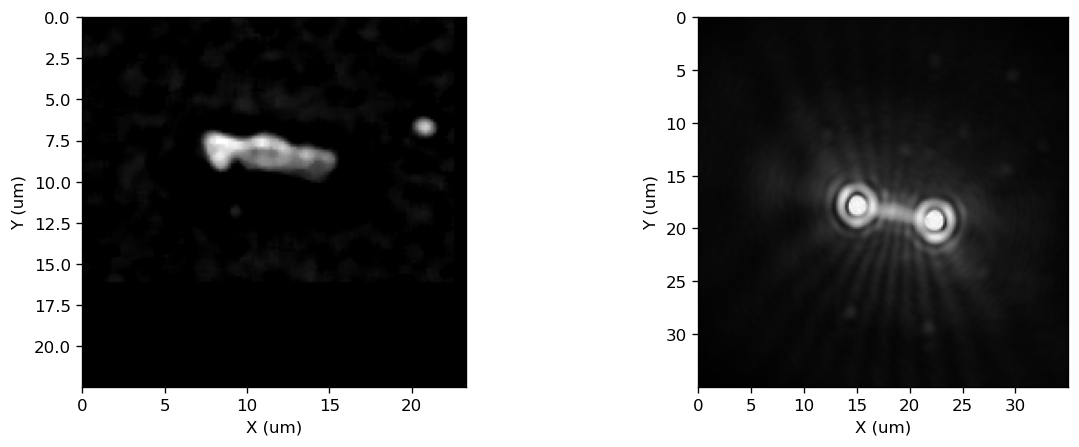

In [118]:
#Choose wire type
typ = 'InP'

#Choose wire ID
ID = 10

#Extract brightfield image
try:
    im = np.squeeze(dataset[typ].raw.image.optical[:,:,ID])
except:
    im = np.zeros((200,200))
    print("Wire not found")

#Extract lasing_image - taken for a subset of wires, use wire_ID field to find the right data
try:
    ID_list = np.squeeze(dataset[typ].raw.image.wire_ID)
    x = np.where(ID_list == ID)
    im_lasing = np.squeeze(dataset[typ].raw.image.above_threshold[:,:,x[0]])
except:
    print("This nanowire does not lase")
    im_lasing = np.zeros((200,200))
    

#Extract pixel size in images (um)
pix_size = 1000*dataset[typ].raw.image.metadata.pixel_size.data[0]

# Create a high-resolution figure and plot the data
plt.figure(figsize=[12,4],dpi = 120)
plt.subplot(121) 
plt.imshow(im, cmap='gray', extent=[0,(im.shape[0]*pix_size[0]),(im.shape[1]*pix_size[0]),0])
plt.xlabel('X (um)')
plt.ylabel('Y (um)')

plt.subplot(122) 
plt.imshow(im_lasing, cmap='gray', extent=[0,(im_lasing.shape[0]*pix_size[0]),(im_lasing.shape[1]*pix_size[0]),0])
plt.xlabel('X (um)')
plt.ylabel('Y (um)')

# Example: plot power dependent PL and interferogram for a single wire

Text(0, 0.5, 'Counts (norm)')

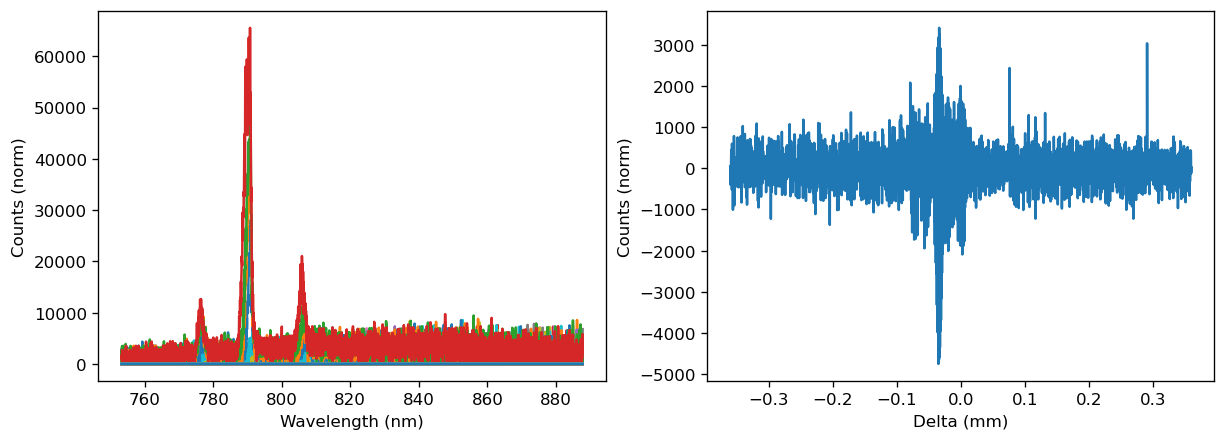

In [149]:
#Choose wire type
typ = 'GaAs'

#Choose wire ID
ID = 108

#extract wavelength
wl = np.squeeze(dataset[typ].raw.pdep_PL.metadata.wl.data)

#Extract power dependence - taken for a subset of wires, use wire_ID field to find the right data
try:
    ID_list = np.squeeze(dataset[typ].raw.pdep_PL.wire_ID)
    x = np.where(ID_list == ID)
    spec = np.squeeze(dataset[typ].raw.pdep_PL.spectrum[:,:,x[0]])
except:
    print("This nanowire does not lase")
    spec = np.zeros((np.size(wl),1))
    

#Extract delta
D = np.squeeze(dataset[typ].raw.interferometry.metadata.delta.data)    

# Extract interferometry - also done for a subset of wires
try:
    ID_list = np.squeeze(dataset[typ].raw.interferometry.wire_ID)
    x = np.where(ID_list == ID)
    inter = np.squeeze(dataset[typ].raw.interferometry.interferogram[x[0],:])
except:
    print("This nanowire does not have an interferogram")
    inter = np.zeros((np.size(D),1))



# Create a high-resolution figure and plot the data
plt.figure(figsize=[12,4],dpi = 120)
plt.subplot(121) 
plt.plot(wl,spec)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Counts (norm)')

plt.subplot(122) 
plt.plot(D - np.mean(D),inter)
plt.xlabel('Delta (mm)')
plt.ylabel('Counts (norm)')


# Example: plot mean PL spectra and parameter boxplots for each wire type

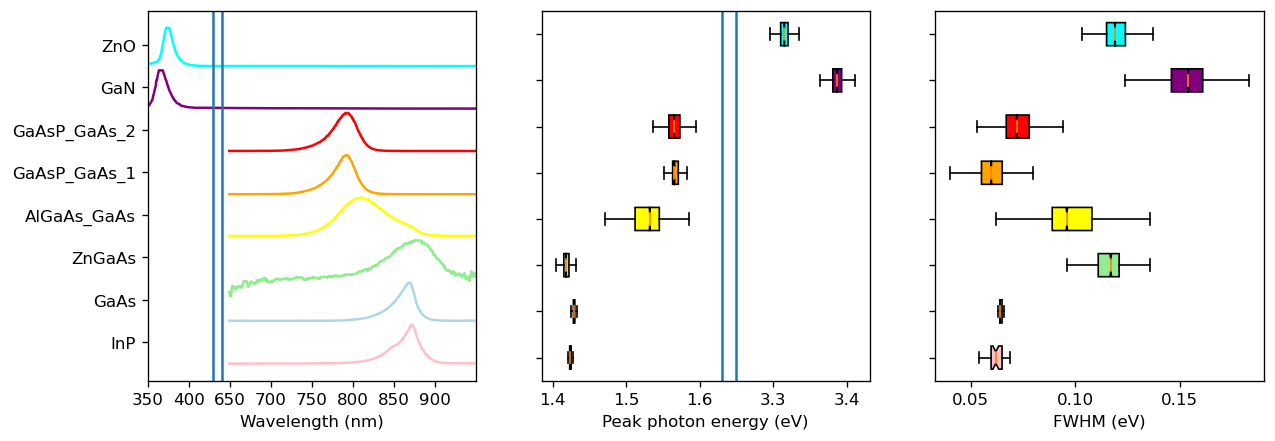

In [7]:
#samples to plot, with colors
samples = {'InP':'pink'
           ,'GaAs':'lightblue'
           ,'ZnGaAs':'lightgreen'
           ,'AlGaAs_GaAs':'yellow'
           , 'GaAsP_GaAs_1':'orange'
           , 'GaAsP_GaAs_2':'red'
           ,'GaN':'purple'
           ,'ZnO':'cyan'}

# Create a high-resolution figure
plt.figure(figsize=[12,4],dpi = 120)


## Show photoluminescence spectra
# Loop over each type of nanowire

#Offset for stacked plot
delta = 1;
offset = 0

plt.subplot(131) 
#Initial PL plot, with axis break
for i in list(samples.keys()):
    # Extract wavelength from PL metadata
    wl = np.squeeze(dataset[i].raw.PL.metadata.wl.data)
    
    #Extract PL spectra from dataset, subtract offset saved in the metadata
    spec = dataset[i].raw.PL.spectrum - dataset[i].raw.PL.metadata.offset[0]
    
    #Calculate mean spectrum, normalise and offset for plotting
    mean_spec = 0.9*n(s(np.mean(spec,1))) + offset
    
    #extra step for GaN and ZnO - shift energy for ease of viewing
    if i == 'GaN' or i == 'ZnO':    
        wl = wl +200


    # plot the same data on both axes
    plt.plot(wl,mean_spec,color = samples[i])

    #Iterate on offset
    offset += delta
    
    
#Format plot
plt.xlabel('Wavelength (nm)')
plt.xlim([600,950])

# Modify ticks to account for energy shift for GaN and ZnO
plt.xticks( [550,600,650,700,750,800,850,900]  , [350,400,650,700,750,800,850,900]  )

# Replace 5 labels with sample names
plt.yticks(range(0, len(list(samples.keys()))), list(samples.keys()))
locs, labels = plt.yticks()  # Get the current locations and labels.
plt.yticks(locs+0.5, list(samples.keys()))

# Indicate 
plt.axvline(x=630)
plt.axvline(x=640)

## Extra photoluminescence stats - bandgap and spectral width
bandgap = {}
FWHM = {}
# Loop over each type of nanowire
for i in samples:
    # Extract stats, removing nans
    x = dataset[i].derived.PL_peak1[0]
    x = x[~np.isnan(x)]
    
    #extra step for GaN and ZnO - shift energy for ease of viewing
    if i == 'GaN' or i == 'ZnO':    
        x = x - 1.6
        
    bandgap[i] =x
    
    x = dataset[i].derived.PL_FWHM1[0]
    x = x[~np.isnan(x)]
    FWHM[i] = x
        
        
# Plot stats
plt.subplot(132) 
labels, data = [*zip(*bandgap.items())]
bplot1 = plt.boxplot(data,vert=False, showfliers=False, notch=True,patch_artist=True)
plt.yticks(range(1, len(labels) + 1), '')
plt.xlabel('Peak photon energy (eV)')
plt.xticks( [1.4,1.5,1.6,1.7,1.8]  , [1.4,1.5,1.6,3.3,3.4]  )
plt.axvline(x=1.63)
plt.axvline(x=1.65)

#assign colors
for patch, color in zip(bplot1['boxes'], list(samples.values())):
    patch.set_facecolor(color)

#Plot stats - FWHM
plt.subplot(133) 
labels, data = [*zip(*FWHM.items())]
bplot2 = plt.boxplot(data,vert=False, showfliers=False, notch=True,patch_artist=True)
plt.yticks(range(1, len(labels) + 1), '')
plt.xlabel('FWHM (eV)')

#assign colors
for patch, color in zip(bplot2['boxes'], list(samples.values())):
    patch.set_facecolor(color)
    
plt.show()
    

# Example: correlate two derived parameters

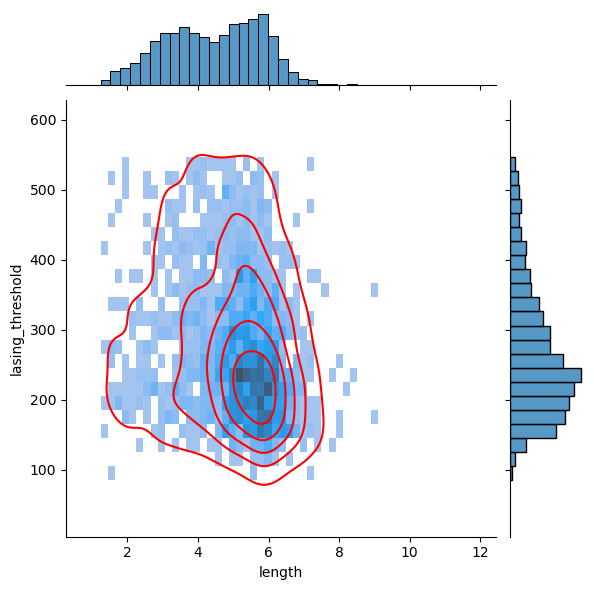

In [249]:
#Choose wire type
typ = 'GaAs'

#Choose parameters to compare
par1 = 'length'
par2 = 'lasing_threshold'


# Restructure for plotting
data = np.zeros((2,np.size(dataset[typ].derived.R[0,:])))
data[0,:] = dataset[typ].derived[par1][0,:]
data[1,:] = dataset[typ].derived[par2][0,:]
df = pd.DataFrame(data.T, columns=[par1,par2])



g = sns.jointplot(data=df,x = par1,y =par2, kind="hist")
g.plot_joint(sns.kdeplot, color="r", zorder=1, levels=6)